# Toy Example for Dirichlet Diffusion Score Model 

In this notebook demo, we provide a quick demo on binarized MNIST dataset. Let's load required libraries first.

In [1]:
import tqdm.notebook

In [2]:
import os
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import tqdm


import pandas as pd
import functools
import numpy as np

# Main file which contrains all DDSM logic
from ddsm import *
import sys
sys.path.append('/home/zl6222/repositories/dna_diffusion')

/home/zl6222/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zl6222/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


### Loading Presampled Noise

While Jacobi diffusion evaluation is more expensive than the commonly used diffusion process with Gaussian stationary distribution, all Jacobi diffusion-related computations can be precomputed prior to training and do not add to training time. This is feasible because we only need to generate samples from two starting points, 0 and 1, for any categorical data. Training time sampling is done by choosing randomly from the pre-sampled samples and scores. 

For presampling weights, you need to presample everything by running ''presample_noise.py'' script provided in the repo. For example,  
```
python presample_noise.py -n 10000 -c 2 -t 400 --out_path . --mode path
```
generates file with 2 categories, 10000 samples, and 400 timepoints. This noise will be used later for training, sampling, and computing negative log likelihood. 

Let's load generated file.

In [3]:
# !CUDA_VISIBLE_DEVICES="2" python presample_noise.py -n 10000 -c 2 -t 400 --out_path . --mode path

In [4]:
v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = torch.load("steps400.cat4.time4.0.samples10000.pth")
if torch.cuda.is_available():
    v_one = v_one.cuda()
    v_zero = v_zero.cuda()
    v_one_loggrad = v_one_loggrad.cuda()
    v_zero_loggrad = v_zero_loggrad.cuda()
    timepoints = timepoints.cuda()

# We have two categories, so the beta parameters are
# alpha = torch.DoubleTensor([1.0])
# beta = torch.DoubleTensor([1.0])

# Example of 4 categories to be used with diffusion_factory
alpha = torch.DoubleTensor([1.0, 1.0, 1.0])
beta = torch.DoubleTensor([3.0, 2.0, 1.0])

### Defining the Model

Now, let's define the score-based model for binarized MNIST data. 

In [ ]:
from diffusers import UNet1DModel

model = UNet1DModel(sample_size=128,
                    in_channels=32,
                    out_channels=32,
                    layers_per_block=2,
                    block_out_channels=[32, 32, 64],
                    down_block_types=['DownBlock1DNoSkip', 'DownBlock1D',
                                      'AttnDownBlock1D'],
                    up_block_types=['AttnUpBlock1D', 'UpBlock1D',
                                    'UpBlock1DNoSkip'],
                    mid_block_type='UNetMidBlock1D')

class ScoreNetLarge(nn.Module):
    def __init__(self, embed_dim=256, time_dependent_weights=None, time_step=0.01):
        super().__init__()
        self.net = UNet1DModel(
                        sample_size=2048, #TODO
                        in_channels=4,
                        out_channels=4,
                        layers_per_block=2,
                        block_out_channels=[16, 32, 64],
                        down_block_types=['DownBlock1DNoSkip', 'DownBlock1D',
                                        'AttnDownBlock1D'],
                        up_block_types=['AttnUpBlock1D', 'UpBlock1D',
                                        'UpBlock1DNoSkip'],
                        mid_block_type='UNetMidBlock1D',
                    )

    def forward(self, x, t):
        return self.net(x, t, return_dict=False)[0]

In [5]:
class Dense(nn.Module):
    """
    A fully connected layer that reshapes outputs to feature maps.
    """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[...]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, embed_dim=256, time_dependent_weights=None, time_step=0.01):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        n = 256
        self.linear = nn.Conv1d(4, n, kernel_size=9, padding=4)
        self.blocks = nn.ModuleList([nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, padding=4),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                                     nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256)])

        self.denses = nn.ModuleList([Dense(embed_dim, n) for _ in range(20)])
        self.norms = nn.ModuleList([nn.GroupNorm(1, n) for _ in range(20)])

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.scale = nn.Parameter(torch.ones(1))
        self.final = nn.Sequential(nn.Conv1d(n, n, kernel_size=1),
                                   nn.GELU(),
                                   nn.Conv1d(n, 4, kernel_size=1))
        self.register_buffer("time_dependent_weights", time_dependent_weights)
        self.time_step = time_step

    def forward(self, x, t, t_ind=None, return_a=False):
        # Obtain the Gaussian random feature embedding for t
        # embed: [N, embed_dim]
        embed = self.act(self.embed(t / 2))

        # Encoding path
        # x: NLC -> NCL
        out = x.permute(0, 2, 1)
        out = self.act(self.linear(out))

        # pos encoding
        for block, dense, norm in zip(self.blocks, self.denses, self.norms):
            h = self.act(block(norm(out + dense(embed)[:, :, None])))
            if h.shape == out.shape:
                out = h + out
            else:
                out = h

        out = self.final(out)

        out = out.permute(0, 2, 1)

        if self.time_dependent_weights is not None:
            t_step = (t / self.time_step) - 1
            w0 = self.time_dependent_weights[t_step.long()]
            w1 = self.time_dependent_weights[torch.clip(t_step + 1, max=len(self.time_dependent_weights) - 1).long()]
            out = out * (w0 + (t_step - t_step.floor()) * (w1 - w0))[:, None, None]

        out = out - out.mean(axis=-1, keepdims=True)
        return out

### Loading DNA Data 

The following code load MNIST data and create binarized version of it.

In [6]:
from src.datasets.lightning_loader import DataModule

class config:
    data_path= "/mnt/data/shared/dna-diffusion/processed_promoter/split_human_mouse_rat_monkey.pt"
    batch_size= 128
    num_workers= 5
    num_processes= 4
    train_prop= 0.95
    valid_prop= 0.05
    shuffle= True
    seed= 50
    generator = torch.Generator().manual_seed(50)

In [7]:
data_module = DataModule(config)
data_module.setup()
train_loader = iter(data_module.train_dataloader())
valid_loader = iter(data_module.val_dataloader())
test_loader = iter(data_module.test_dataloader())

data loaded!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!torch.Size([62562, 2048, 4])


Let's load training/validation/test datasets and dataset for importance sampling weights estimation. 

In [8]:
weights_est_dl = data_module.train_dataloader()

In [9]:
training_dl = data_module.train_dataloader()

### Global Parameters 

We define a few global parameters for our model

In [10]:
# number of categories are 2 for binarized MNIST data
C = 4

# device, where code will be run
device = "cuda" # alternative option is "cpu"

# setting speed_balanced does not have an effect for C=2
# For >2 categories, setting speed_balanced flag affects the convergence speed of the forward diffusion.
# (see Appendix A.2)
# speed_balanced = True leads to similar convergence speed across individual univariate Jacobi diffusion processes
# speed balanced = False leads to similar convergence speed across different categories after stick breaking transform

speed_balanced = False

if speed_balanced:
    s = 2 / (
        torch.ones(C - 1, device=device)
        + torch.arange(C - 1, 0, -1, device=device).float()
    )
else:
    s = torch.ones(C - 1, device=device)

# Number of epochs for training
num_epochs = 50

Jacobi diffusion process converges to Beta stationary distribution, a univariate special case of Dirichlet distribution. Using the connection between Beta distribution and Dirichlet distribution, we construct a
multivariate diffusion process on probability simplex that converges to Dirichlet distribution with k − 1 independent univariate Jacobi diffusion processes by a classical stick- breaking construction (see Paragraph 3.2 for more details) 

In [11]:
sb = UnitStickBreakingTransform()

### Computing Importance Sampling Weights 

Importance sampling is often needed to stabilize the training of diffusion model with likelihood weighting, since the scores for the forward diffusion transition density functions are usually large when time is small. Importance sampling is thus used as a variance reduction technique that samples time non-uniformly during training. By sampling time points where the scale of the score is higher more often and down-weight the sample loss accordingly, the variance of the gradient can be reduced. We determine the importance sampling weight based on the scale of the scores at each time point observed empirically. The choice of using importance sampling or not or the form of importance sampling weights depends on your applications.

In [12]:
n_time_steps = timepoints.shape[0]

time_dependent_cums = torch.zeros(n_time_steps).to(device)
time_dependent_counts = torch.zeros(n_time_steps).to(device)

for i, x in enumerate(weights_est_dl):
    x = x.squeeze()
    random_t = torch.randint(0, n_time_steps, (x.shape[0],))
    order = np.random.permutation(np.arange(C))

    # There are two options for using presampled noise:
    # First one is regular approach and second one is fast sampling (see Appendix A.4 for more info)
    perturbed_x, perturbed_x_grad = diffusion_factory(
        x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta
    )
    # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)

    perturbed_x = perturbed_x.to(device)
    perturbed_x_grad = perturbed_x_grad.to(device)
    random_t = random_t.to(device)

    # Transform data from x space to v space, where diffusion happens
    order = np.random.permutation(np.arange(C))
    perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()

    # Computing score. gx_to_gv transforms gradient in x space to gradient in v space
    time_dependent_cums[random_t] += (
            (perturbed_v * (1 - perturbed_v)
                * s[(None,) * (x.ndim - 1)]
                * gx_to_gv(perturbed_x_grad, perturbed_x, compute_gradlogdet=False)** 2
            ).view(x.shape[0], -1).mean(dim=1).detach()
        )

    time_dependent_counts[random_t] += 1

time_dependent_weights = time_dependent_cums / time_dependent_counts
time_dependent_weights = time_dependent_weights / time_dependent_weights.mean()


The following plot verifies that our importance sampling weights are nice. It should be monotonic decreasing curve.

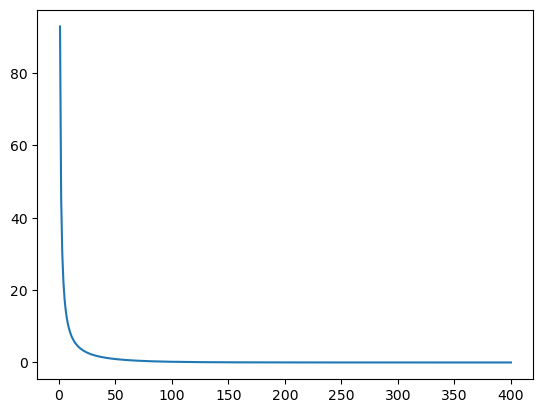

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, n_time_steps + 1), time_dependent_weights.cpu())

### Training

The following code trains the model and do validation check every 10 epochs.

In [14]:
#the score loss is computed in the v-space
def loss_fn(score, perturbed_x_grad, perturbed_x, important_sampling_weights=None):
    perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()
    if important_sampling_weights is not None:
        important_sampling_weights = 1/important_sampling_weights[
                    (...,) + (None,) * (x.ndim - 1)]
    else:
        important_sampling_weights = 1
    loss = torch.mean(
            torch.mean(
                important_sampling_weights
                * s[(None,) * (x.ndim - 1)]
                * perturbed_v * (1 - perturbed_v)
                * (gx_to_gv(
                        score, perturbed_x, create_graph=True, compute_gradlogdet=False
                    ) - gx_to_gv(perturbed_x_grad, perturbed_x, compute_gradlogdet=False)
                  ) ** 2,
                dim=(1))
        )
    return loss


In [15]:
torch.set_default_dtype(torch.float32)

# Defining a model
score_model = ScoreNet()
score_model = score_model.to(device)
score_model.train()

# Defining optimizer
lr = 5e-4
optimizer = Adam(score_model.parameters(), lr=lr, weight_decay=1e-10)

timepoints = timepoints.cuda()

tqdm_epoch = tqdm.notebook.trange(num_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0

    for x in tqdm.notebook.tqdm(training_dl):
        x = x.squeeze()
        random_t = torch.LongTensor(
            np.random.choice(
                np.arange(n_time_steps),
                size=x.shape[0],
                p=(
                    torch.sqrt(time_dependent_weights)
                    / torch.sqrt(time_dependent_weights).sum()
                )
                .cpu()
                .detach()
                .numpy(),
            )
        ).to(device)

        # Similarly to computing importance sampling weights, there are two options
        perturbed_x, perturbed_x_grad = diffusion_factory(
            x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta
        )
        # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)

        perturbed_x = perturbed_x.to(device)
        perturbed_x_grad = perturbed_x_grad.to(device)
        random_t = random_t.to(device)
        random_timepoints = timepoints[random_t]

        # Doing score estimation via neural network
        score = score_model(perturbed_x, random_timepoints)

        # Computing loss function
        loss = loss_fn(score, perturbed_x_grad, perturbed_x,
                       important_sampling_weights=(torch.sqrt(time_dependent_weights))[random_t])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    print("Average Loss: {:5f}".format(avg_loss / num_items))

    # # Doing validation check every 10 epochs.
    # if epoch % 10 == 0:
    #     valid_avg_loss = 0.0
    #     valid_num_items = 0

    #     for x in valid_datasets:

    #         x = binary_to_onehot(x.squeeze())
    #         random_t = torch.LongTensor(
    #             np.random.choice(
    #                 np.arange(n_time_steps),
    #                 size=x.shape[0],
    #                 p=(
    #                     torch.sqrt(time_dependent_weights)
    #                     / torch.sqrt(time_dependent_weights).sum()
    #                 ).cpu().detach().numpy(),
    #             )
    #         ).to(device)

    #         perturbed_x, perturbed_x_grad = diffusion_factory(
    #             x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta
    #         )
    #         # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)

    #         perturbed_x = perturbed_x.to(device)
    #         perturbed_x_grad = perturbed_x_grad.to(device)
    #         random_t = random_t.to(device)
    #         random_timepoints = timepoints[random_t]

    #         score = score_model(perturbed_x, random_timepoints)
    #         loss = loss_fn(score, perturbed_x_grad, perturbed_x,
    #                    important_sampling_weights=(torch.sqrt(time_dependent_weights))[random_t])

    #         valid_avg_loss += loss.item() * x.shape[0]
    #         valid_num_items += x.shape[0]

    #     print("Average Loss: {:5f}".format(valid_avg_loss / valid_num_items))


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 1.411242


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.527283


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.511794


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.510826


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.564540


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.508458


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.505496


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.507468


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.501824


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.502702


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.505656


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.506756


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.501214


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.503187


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.504538


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.500285


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.498754


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.494464


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.492945


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.495241


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.492998


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.489928


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.494361


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.489260


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.490317


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.484835


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.490547


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.487836


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.834641


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.523781


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.509526


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.504253


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.506644


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.496381


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.497322


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.493567


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.490222


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.494237


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.488506


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.488518


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.487204


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.484977


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.488547


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.485269


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 1.475134


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.617003


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.533812


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.516298


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.514255


  0%|          | 0/465 [00:00<?, ?it/s]

Average Loss: 0.508192


In [18]:
sampler = Euler_Maruyama_sampler ## Generate samples using the specified sampler.
samples = sampler(score_model, (2048,4),
                            batch_size=10,
                            max_time= 4,
                            min_time=0.01,
                            num_steps=100,
                            eps=1e-5,
                            device=device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.60it/s]


In [22]:
from src.utils.tensor_to_dna import tensor_to_dna
from src.utils.evaluator import write_to_fasta
print(samples.shape, samples[0])
dna = [tensor_to_dna(ele) for ele in samples]
write_to_fasta(dna, "ddsm_test.fasta")
# torch.save(score_model.state_dict(), 'good_models.pth')

torch.Size([10, 1024, 4]) tensor([[2.2918e-01, 1.0722e-02, 1.2997e-02, 7.4710e-01],
        [1.5258e-02, 9.6008e-01, 8.2729e-03, 1.6388e-02],
        [1.4188e-02, 9.6039e-01, 2.4914e-02, 5.0740e-04],
        ...,
        [3.5904e-02, 1.2242e-02, 1.8985e-02, 9.3287e-01],
        [1.5685e-02, 1.1072e-02, 9.7324e-06, 9.7323e-01],
        [8.6245e-01, 1.0761e-01, 2.6697e-02, 3.2479e-03]], device='cuda:0')


### Sampling Examples from Dataset. 

Let's sample a few examples from the model by using simple Euler-Maruyama sampler. 

In [23]:
from src.utils.tensor_to_dna import tensor_to_dna
# generate samples from trained model
torch.set_default_dtype(torch.float32)
score_model.eval()

device = 'cuda'

sample_batch_size = 100
total_num_samples = 5000
sampler = Euler_Maruyama_sampler ## Generate samples using the specified sampler.


for i in tqdm.notebook.tqdm(range(total_num_samples//sample_batch_size)):
    samples = sampler(score_model, (2048,4),
                            batch_size=sample_batch_size,
                            max_time= 4,
                            min_time=0.01,
                            num_steps=100,
                            eps=1e-5,
                            device=device)
    print(samples.shape)
    dna = [tensor_to_dna(ele) for ele in samples]
    write_to_fasta(dna, "ddsm.fasta")
# for the last sample
samples = sampler(score_model, (2048,4),
                            batch_size=total_num_samples%sample_batch_size,
                            max_time= 4,
                            min_time=0.01,
                            num_steps=100,
                            eps=1e-5,
                            device=device)
print(samples.shape)
dna = [tensor_to_dna(ele) for ele in samples]
write_to_fasta(dna, "ddsm.fasta")

  0%|          | 0/50 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.39it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 440.32it/s]

torch.Size([0, 2048, 4])


We also propose technique called **time dialation** to improve sample quality (see Appendix A.5 and B.9). 

Comparing to unbiasedly sample from the learned model distribution, it is often desirable to sample near the high probability density regions, which often corresponds to higher quality samples in suitable application. Time dilation is applicable to reverse diffusion sampling without modifying the score model, when a flat distribution such as the flat Dirichlet distribution is the stationary distribution. Our sampler implementation support time dilation technique out-of-box.  

In [25]:
#generate samples with time dilation
allsamples_dilate = []
for i in range(total_num_samples//sample_batch_size):
    samples = sampler(score_model,
                            (2048,4),
                            batch_size=sample_batch_size,
                            max_time= 4,
                            min_time=0.01,
                            num_steps=100,
                            time_dilation=8,
                            time_dilation_start_time=1,
                            eps=1e-5,
                            device=device)
    print(samples.shape)
    dna = [tensor_to_dna(ele) for ele in samples]
    write_to_fasta(dna, "ddsm_td8.fasta")
# for the last sample
samples = sampler(score_model,
                        (2048,4),
                        batch_size=total_num_samples%sample_batch_size,
                        max_time= 4,
                        min_time=0.01,
                        num_steps=100,
                        time_dilation=8,
                        time_dilation_start_time=1,
                        eps=1e-5,
                        device=device)
print(samples.shape)
dna = [tensor_to_dna(ele) for ele in samples]
write_to_fasta(dna, "ddsm_td8.fasta")
## Sample visualization.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.45it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.42it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.40it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:50<00:00,  5.41it/s]


torch.Size([100, 2048, 4])
